#  Artists in the Billboard

# Classification Algorithm - Decession Trees

## 1 Introduction 

In this document we will review the performance of the Decession Tree Classifier analying a data set composed of information about singers and bands that achieved a number one spot on the Billboard Hot 100 charts. Our goal is to build a good Machine Learning model, which has to predict predict who will be the next "top singer/band".

The dataset that we will use for our analysis is called "artists_billboard.csv". You can find it in the Files folder of this repository.  

## 2 Import the necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.core.display import Image
from sklearn.tree import export_graphviz

## 3 Explore the data 

In [8]:
#Load the data set
df = pd.read_csv('artists_billboard.csv', sep=',')
df.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


In [5]:
df.shape

(635, 11)

The data set has a total of 635 records (lines) and 11 features (columns).

## 4  Data Visualization 

Before displaying the data, let's group the records to see how many artists have achieved the position 1 and not:

In [9]:
#grouping the records under TOP column
df.groupby('top').size()

top
0    494
1    141
dtype: int64

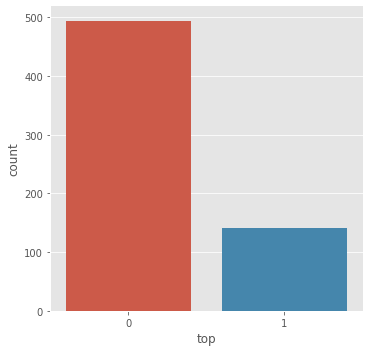

In [15]:
#visualization of the TOP data
sb.factorplot('top',data=df,kind="count", aspect=1)

Comments => We can see that there are a total of 494 songs that did not reach the top, while a total of 141 songs could reach the top 1. Therefore, we have a UNBALANCED number of labels with 1 and 0. So, we will take this into account when creating the tree.

Now, let's check how many records of "artist type", "mood", "time" and "genre" there are in the data set. 

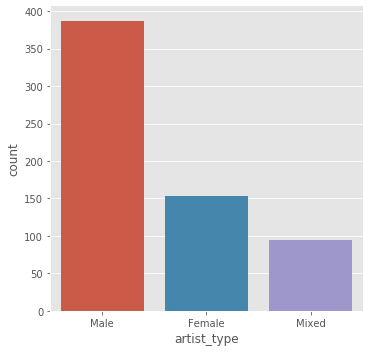

In [16]:
#visualization of the Artist_type data
sb.factorplot('artist_type',data=df,kind="count", aspect=1)

Comments => We can see that more than the double of artists are male, while only 150 artists are female. In addition, 100 records are related to mixed songs.

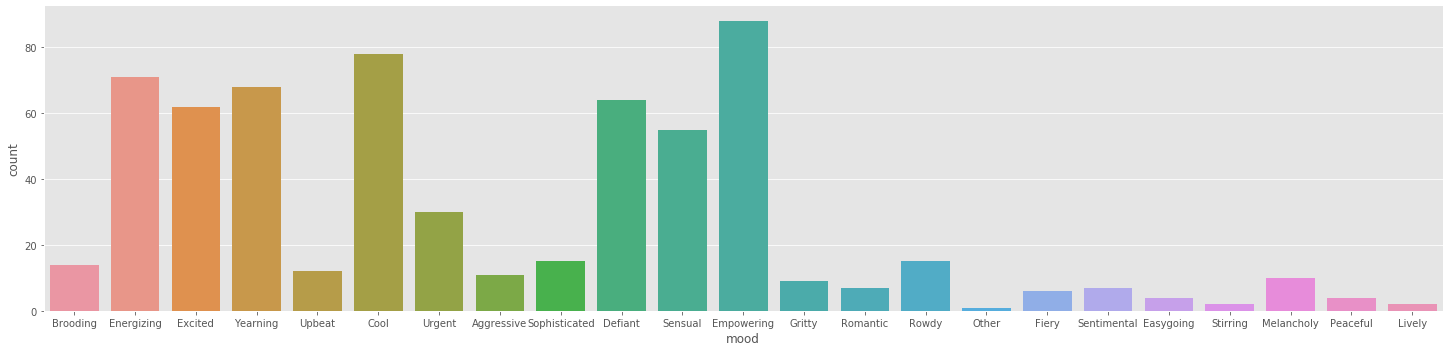

In [21]:
#visualization of the Mood data
sb.factorplot('mood',data=df,kind="count", aspect = 4)

Comments => We can see that of 23 types of Mood, 7 stand out with high peaks. We also noticed that some moods are similar.

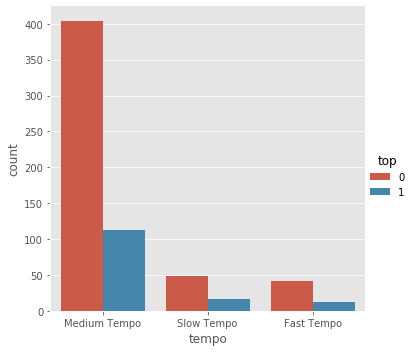

In [23]:
#visualization of the Time data
sb.factorplot('tempo', data=df, hue='top', kind="count")

Comments => We see that there are 3 types of time (Medium, Slow and Fast). The Medium times predominate and it is also where we find more songs that have reached the Top 1 (in blue).

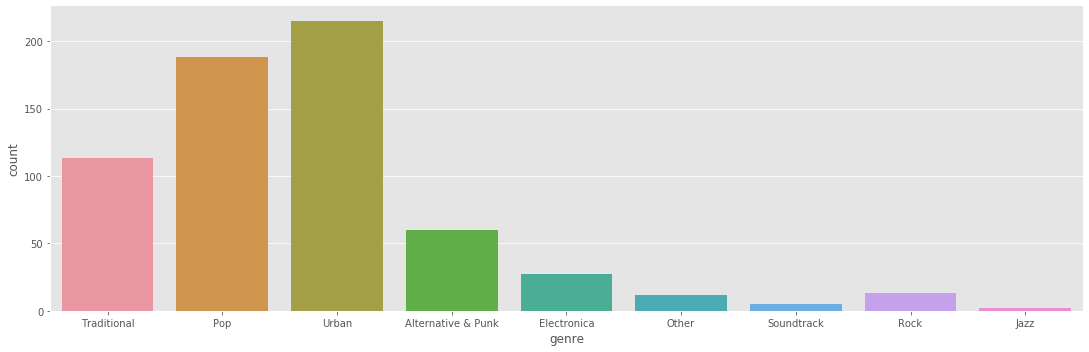

In [24]:
#visualization of the Genre
sb.factorplot('genre',data=df,kind="count", aspect=3)

Comments => In the musical genres, Urban and Pop stand out, followed by Traditional and Alternative & Punk.

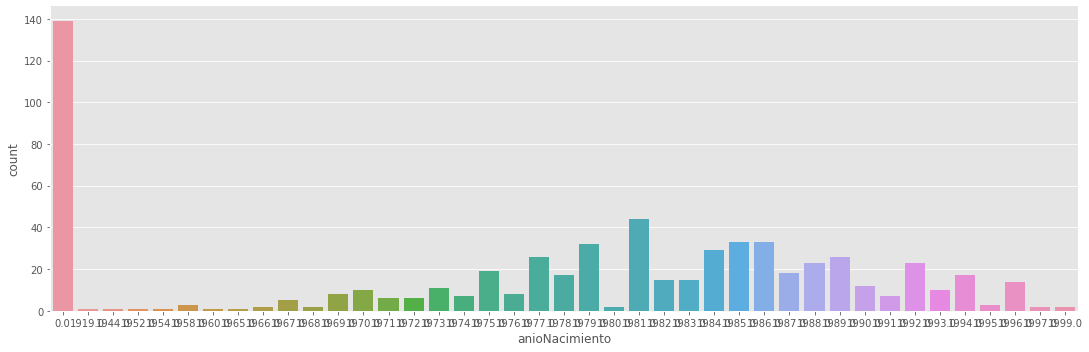

In [25]:
#Visualization of the artist's "Year of birth"
sb.factorplot('anioNacimiento',data=df,kind="count", aspect=3)

Comments => We can see that about 140 songs are allocated in the 0 year due to the fact that we do not know the year of birth of the artist. The rest of the years seem to concentrate between 1979 and 1994. Later we will take care of this records.

## 5 Data Processing 

### 5.1 Age_in_billboard Calculation

The feature that we want to obtain is: «knowing the singer's year of birth, calculate how old he was at the time of appearing on the Billboard»

For that, firstly, we need to solve the issue with the 0 records under the "anioNacimiento" column. For that, we will replace the 0 values for the None value (null value in python).

In [26]:
#replace 0 values for None
def age_fix(year):
    if year==0:
        return None
    return year

df['anioNacimiento']=df.apply(lambda x: age_fix(x['anioNacimiento']), axis=1);

Then, we will calcute the ages in anew column called "age_in_billboard", subtracting the year of appearance (the first 4 characters of chart_date) to the year of birth. In the lines with None value, we will get a None age as result.

In [27]:
#calculate the "age_in_billboard" feature values
def age_calculation(year,when):
    cad = str(when)
    moment = cad[:4]
    if year==0.0:
        return None
    return int(when) - year

df['age_in_billboard']=df.apply(lambda x: age_calculation(x['anioNacimiento'],x['chart_date']), axis=1);

Finally, we will assign random ages to the missing records. For that, we will get the average age of our set (avg) and the standard deviation (std). Therefore, we will need the ages in None and we will request random values to the function ranging from avg - std to avg + std (ages between 21 to 37 years).

In [29]:
#calculate the mean and std of the values under "age_in_billboard" column
age_avg = df['age_in_billboard'].mean()
age_std = df['age_in_billboard'].std()
age_null_count = df['age_in_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
 
conNullValues = np.isnan(df['age_in_billboard'])

df.loc[np.isnan(df['age_in_billboard']), 'age_in_billboard'] = age_null_random_list
df['age_in_billboard'] = df['age_in_billboard'].astype(int)

print("Average Age: " + str(age_avg))
print("Standard Deviation Age: " + str(age_std))
print("Interval to assign random agea: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Average Age: 20125302.389112905
Standard Deviation Age: 28711.734117256008
Interval to assign random agea: 20096590 a 20154014


### 5.2 Data Mapping 

We will transform several of the input data into categorical values. The ages, we separate them into: under 21, between 21 and 26, etc. song durations too, e.g. between 150 and 180 seconds, etc. For moods I grouped those that were similar.

Regarding the time, it will be mapped in the following way:0-Fast, 1-Slow, 2-Medium (by number of songs in each tempo: the Medium is the one that has the most).

In [30]:
# Mood Mapping 
df['moodEncoded'] = df['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)

# Time Mapping 
df['tempoEncoded'] = df['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '':0} ).astype(int)

# Genre Mapping 
df['genreEncoded'] = df['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                         'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0}).astype(int)
                                       
# artist_type Mapping 
df['artist_typeEncoded'] = df['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)

In [31]:
# Mapping age when the artists reach the billboard
df.loc[ df['age_in_billboard'] <= 21, 'edadEncoded']                         = 0
df.loc[(df['age_in_billboard'] > 21) & (df['age_in_billboard'] <= 26), 'edadEncoded'] = 1
df.loc[(df['age_in_billboard'] > 26) & (df['age_in_billboard'] <= 30), 'edadEncoded'] = 2
df.loc[(df['age_in_billboard'] > 30) & (df['age_in_billboard'] <= 40), 'edadEncoded'] = 3
df.loc[ df['age_in_billboard'] > 40, 'edadEncoded'] = 4
 
# Mapping Song Duration
df.loc[ df['durationSeg'] <= 150, 'durationEncoded']                          = 0
df.loc[(df['durationSeg'] > 150) & (df['durationSeg'] <= 180), 'durationEncoded'] = 1
df.loc[(df['durationSeg'] > 180) & (df['durationSeg'] <= 210), 'durationEncoded'] = 2
df.loc[(df['durationSeg'] > 210) & (df['durationSeg'] <= 240), 'durationEncoded'] = 3
df.loc[(df['durationSeg'] > 240) & (df['durationSeg'] <= 270), 'durationEncoded'] = 4
df.loc[(df['durationSeg'] > 270) & (df['durationSeg'] <= 300), 'durationEncoded'] = 5
df.loc[ df['durationSeg'] > 300, 'durationEncoded'] = 6

Finally, we get a new set called artists_encoded, in which we have all the definitive attributes to build our tree. Therefore, we can remove all the features that we do not need in our analysis.

In [32]:
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','age_in_billboard']
artists_encoded = df.drop(drop_elements, axis = 1)

In [33]:
artists_encoded.head()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0,4,2,2,3,4.0,2.0
1,0,6,2,3,2,4.0,6.0
2,1,5,2,4,1,4.0,3.0
3,0,4,2,1,3,4.0,2.0
4,0,4,2,2,2,4.0,3.0


In [37]:
artists_encoded.shape

(635, 7)

### 5.3 Data Mapping Display

In [ ]:
#In the column sum we will find the top ones, since being value 0 or 1, only those that did reach number 1 will be added.

In [34]:
#Check how the top=1 are splitted along the moodEncoded feature
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

Comments => We see most of the top 1 in moods 5 and 6 with 46 and 43 songs

In [35]:
#Check how the top=1 are splitted along the artist_typeEncoded feature
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

In [36]:
#Check how the top=1 are splitted along the genreEncoded feature
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

In [38]:
#Check how the top=1 are splitted along the tempoEncoded feature
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

In [39]:
#Check how the top=1 are splitted along the durationEncoded feature
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

In [41]:
#Check how the top=1 are splitted along the edadEncoded feature
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                 mean count  sum
edadEncoded                     
4.0          0.222047   635  141

## 6 Predict and Evaluation 

### 6.1 Training and Test Split 

In [43]:
x_train = artists_encoded.drop(['top'], axis=1).values    # X variable = store the data
y_train = artists_encoded['top']  # y variable = store the classes/targets

### 6.2 Apply the Decission Tree Classifier 

Before starting building the decission trees, we need to identify the depth that we will assign to the tree. To do this, we will take advantage of the "KFold function" that will help us create several subgroups with our input data to validate and assess trees with varying levels of depth. Then, we will choose the one with the best result.

In [42]:
# Desired number of "folds" that we will do
cv = KFold(n_splits=10) 
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)
 
# Test the depth
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold] 
        f_valid = artists_encoded.loc[valid_fold] 
 
        model = tree_model.fit(X = f_train.drop(['top'], axis=1), 
                               y = f_train["top"]) 
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1), 
                                y = f_valid["top"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Show the results
df_results = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df_results = df_results[["Max Depth", "Average Accuracy"]]
print(df_results.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.556101
         2          0.556101
         3          0.623710
         4          0.617460
         5          0.618973
         6          0.607812
         7          0.617312


Comments => We can see that in 4 levels of splits we have the highest score, with almost 65%.

### 6.3 Decession Tree Visualization 

Now, we need to create and visualize our tree 4 levels deep.

We assign the input data and the parameters that we previously configured with 4 levels of depth. Then, we will use the export_graphviz function to create a .dot extension file that we will then convert into a png graphic to visualize the tree.

In [45]:
# Build the decession tree with a depth of 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})


#Apply the Decession Tree Classifier
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={1: 3.5}, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [65]:
# Export the model to a .dot
from sklearn.tree import export_graphviz #method that allows export the decession tree results to a dot file
from pydotplus import graph_from_dot_data #build the graph and export to PNG

dot_data = export_graphviz(decision_tree,
                              out_file= 'tree1.dot',
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )

import os #manipulate data and directories structures (read and write files)
os.system("dot -Tpng tree1.dot -o tree1.png")

1

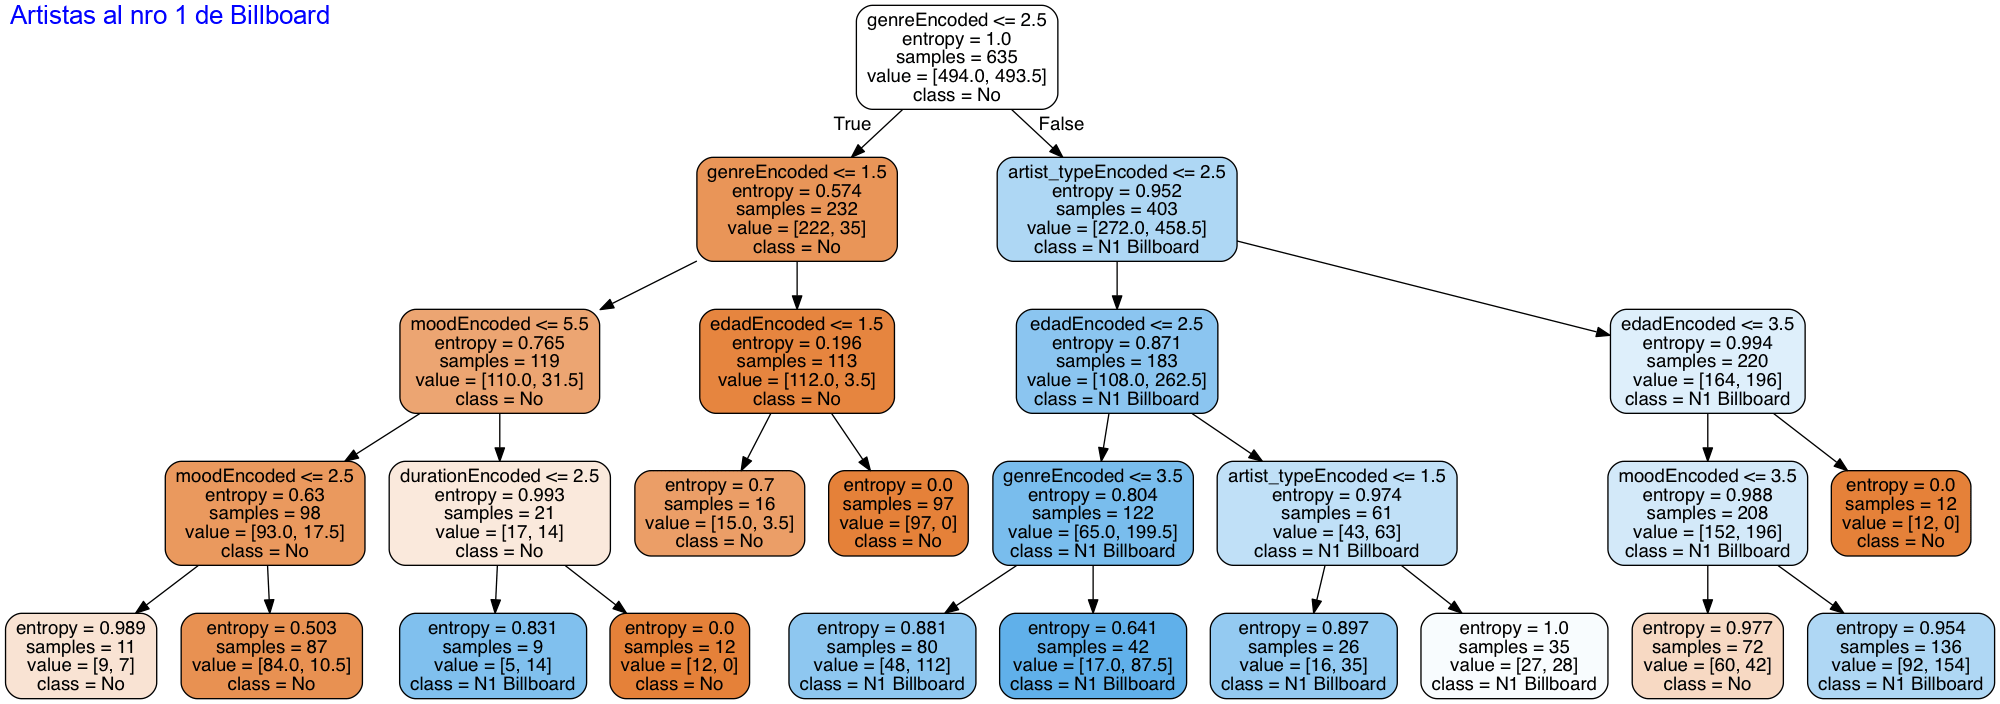

In [67]:
#Visualize the decession tree

from IPython.core.display import Image
Image("arbol-decision-billboard.png")

In [68]:
#check the precission of the decession tree
accuracy = round(decision_tree.score(x_train, y_train) * 100, 2)
print(accuracy)

66.3


Comments => We got a value of 64.88%. We notice that almost all the final leaves of the tree have mixed samples, especially in the output to classify the top = 1, which is causing the reduction in the scor.

### 6.4 Predicting new values 

We are going to test our tree with 2 artists who entered billboard 100 in 2017: "Camila Cabello" who reached number 1 with the Havana song and "Imagine Dragons" with her song Believer that reached a 42nd position but did not reach the top.

In [73]:
#predict artist CAMILA CABELLO featuring YOUNG THUG
 
x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred]* 100, 2))+"%")

Prediccion: [1]


TypeError: type numpy.ndarray doesn't define __round__ method

Comments => The model has predicted that Camila Cabello will reach the top 1 of the most famous artists in the future, as we got a result of 1 in the prediction.

In [72]:
#predict artist Imagine Dragons 
 
x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred]* 100, 2))+"%")

Prediccion: [0]


TypeError: type numpy.ndarray doesn't define __round__ method

Comments => The model has predicted that Imagine Dragons will not reach the top 1 of the most famous artists in the future, as we got a result of 0 in the prediction.